This is based on Fabian Pedregosas [blog](https://fa.bianp.net/blog/2013/logistic-ordinal-regression/) and deprecated [github](https://github.com/fabianp/minirank/blob/master/minirank/logistic.py)

In [144]:
import numpy as np
from numpy.random import default_rng
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy import optimize, linalg, sparse
from matplotlib import pyplot as plt

In [4]:
rng = default_rng(1234)

# Simulation Data

Use a subsample of the simulation data for testing


In [5]:
from masterthesis.data import load_h5ad, load_acinar
data = load_h5ad("/home/julian/Uni/MasterThesis/data/simdata.h5ad")

In [6]:
idx = data.var['Setting'] == "TS"  # extract only the time series samples
sim_X = data.X[:, idx]
sim_y = data.obs["Ordinal_Time_Labels"]

In [7]:
# random subsample genes
y_idx = rng.choice(np.arange(sim_y.size), size=sim_y.size // 2, replace=False)
x_idx = rng.choice(np.arange(sim_X.shape[1]), size=sim_X.shape[1] // 4, replace=False)
sim_X = sim_X[y_idx, :]
sim_X = sim_X[:, x_idx]
sim_y = sim_y[y_idx]

In [8]:
scaler = StandardScaler()
sim_X = scaler.fit_transform(sim_X)

In [9]:
print(sim_X.shape)
print(sim_y.shape)

(286, 1031)
(286,)


# Acinar Data

In [10]:
acinar_ann = load_acinar()

In [11]:
# selected Genes after preprocessing in R
sel_genes = ["REG3A", "AMY2A", "MT2A", "OLFM4",
             "SYCN", "CELA2B", "FGL1", "AMY2B",
             "MT1G", "TM4SF1", "CELA2A", "PDK4", 
             "TACSTD2", "CD44", "PNLIPRP2", "ALB", 
             "ERP27", "LDHA", "REG3G", "CTRL", "CLPS",
             "FOS", "HSPA8", "SERPINA3", "CELA3B", "CRP"]

In [12]:
from sklearn.model_selection import train_test_split

ac_y = np.array([int(x) for x in acinar_ann.obs.donor_age])
ac_label_conv = dict(zip(np.unique(ac_y), range(len(ac_y))))
ac_y = np.array([ac_label_conv[l] for l in ac_y])
k = len(np.unique(ac_y))

ac_X_train, ac_X_test, ac_y_train, ac_y_test = train_test_split(acinar_ann[:,sel_genes].X, ac_y, 
                                                                test_size=0.1, 
                                                                stratify=ac_y,
                                                                random_state=1234)

In [13]:
scaler = StandardScaler()
ac_X_train = scaler.fit_transform(ac_X_train)
ac_X_test = scaler.fit_transform(ac_X_test)

## Gradient DIY

In [268]:
BIG = 1e10
SMALL = 1e-6

def phi(beta, thresholds, X):
    phi = 1 / (1 + np.exp(beta.T @ X - thresholds))
    return phi

def l1_regularizer(beta, l):
    return l * np.sum(np.abs(beta))

# PROBLEM: Is the objective minimized or maximized?? -> Scipy MINIMIZES
# PROBLEM: What if diff is negative? -> Log has issues, but value may be meaningful
# PROBLEM 2: What if diff is too small? -> Log will explode
# PROBLEM 3: Loss of precision?
# log likelihood with regularization as objective function
def objective(params, X, y, k, lamb=0.1, scale_by_y=True):
    
    beta = params[:-k]
    theta = params[-k:]
    thresholds = np.array([theta[i] for i in y])
    thresholds_m1 = np.array([theta[max(0, i-1)] for i in y]) 

    # fit term
    idx = (thresholds > 0)
    diff = np.zeros_like(thresholds)
    phi_i = phi(beta, thresholds, X)
    phi_im1 = phi(beta, thresholds_m1, X)
    
    diff[idx] = (phi_i - phi_im1)[idx]
    diff[~idx] = phi_i[~idx]

    # cut off the difference at a minimum to avoid PROBLEM 2
    #if diff.min() < SMALL:
    #    diff = np.maximum(diff, SMALL)
    
    loglik = np.log(diff, out=np.zeros_like(diff), where=diff>0)
    
    loglik = np.sum(loglik)

    # regularization term
    loglik -= l1_regularizer(beta, lamb)
    
    # scale the loss with the inverse number of samples to handle PROBLEM 3
    if scale_by_y:
        loglik *= (1 / y.size)

    return loglik

def loss(*args, **kwargs):
    return - objective(*args, **kwargs)

def objective_grad(params, X, y, k, lamb=0.1, scale_by_y=True):
    beta = params[:-k]
    theta = params[-k:]
    thresholds = np.array([theta[i] for i in y])
    thresholds_m1 = np.array([theta[max(0, i-1)] for i in y])

    # PROBLEM: thresholds_m1 - thresholds can be 0 -> then the denominator becomes 0!
    idx = (thresholds > 0)
    diff = np.zeros_like(thresholds)
    phi_i = phi(beta, thresholds, X)
    phi_im1 = phi(beta, thresholds_m1, X)
    
    diff[idx] = (phi_i - phi_im1)[idx]
    diff[~idx] = phi_i[~idx]
    
    # BETA UPDATE
    beta_grad = np.sum(X * (1 - diff), axis=1)
    
    # derivative of regularizer over beta scaled
    beta_grad += np.sum(np.sign(beta) * (beta == 0)) * lamb
    
    # THETA UPDATE
    # first half of the gradient
    e = np.identity(k)
    e_expanded = np.concatenate([e[i] for i in y]).reshape(y.size, k).T
    
    temp = (1 
            - phi(beta, thresholds, X) 
            - np.exp(np.log(1 - (1 - np.exp(diff)))))
    t1 = e_expanded @ temp
    
    # second half of the gradient
    e_m1 = np.identity(k+1)[1:,:-1]  # identity with diagonal shifty up by one
    e_m1_expanded = np.concatenate([e_m1[i] for i in y]).reshape(y.size, k).T
    temp = (1 
            - phi(beta, thresholds_m1, X) 
            - np.exp(np.log(1 - (1 - np.exp(-1 * (diff))))))
    
    t2 = e_m1_expanded @ temp
    
    theta_grad = t1 + t2
    
    # scaling
    if scale_by_y:
        theta_grad = theta_grad * (1/theta.size)
        beta_grad = beta_grad * (1/beta.size)

    return np.concatenate([beta_grad, theta_grad])

In [130]:
from scipy.optimize import minimize

def train(obj, grad, X, y, lamb=0.9, scaling=False, method="BFGS"):
    # flip such that X -> (genes, cells)
    if X.shape[0] == y.size:
        X = X.T
    
    n_classes = np.unique(y).size
    params = np.zeros(X.shape[0] + n_classes)
    
    m = minimize(obj, params_nm, args=(X, y, n_classes, lamb, scaling), jac=grad, method=method)
    print(m)
    print(m.x)

In [229]:
train(loss, objective_grad, ac_X_train, ac_y_train, lamb=0., scaling=True, method="bfgs")

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.5597674514599625
        x: [ 2.996e-17 -9.122e-17 ... -1.009e-16 -3.296e-17]
      nit: 0
      jac: [-4.539e-03 -9.223e-04 ... -6.945e-02 -1.042e-01]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 18
     njev: 6
[ 2.99552789e-17 -9.12238797e-17  8.43373503e-17  6.28923016e-17
  1.29517064e-16  2.35470728e-16  4.64152560e-18 -2.37379072e-17
  9.33068062e-17 -1.31213310e-16  8.47381150e-17 -9.14277033e-18
 -1.10647317e-16 -5.55542955e-17  4.15674610e-17 -7.28795221e-17
  1.25000000e-04 -3.91915815e-17  1.01399459e-16  2.16536932e-16
  6.13107712e-15  1.23078388e-16  1.16260966e-16  1.76600273e-17
  1.35598036e-16  7.26746491e-17  1.25000000e-04  1.30296841e-16
  1.45441669e-16 -1.72678216e-17 -1.87164751e-16 -4.54465550e-17
 -1.00882237e-16 -3.29592381e-17]


In [44]:
from scipy.optimize import minimize

scale_by_y = False
lamb = 0.9
n_classes = np.unique(ac_y_train).size
params = np.zeros(ac_X_train.shape[1] + n_classes)

# random params
params_rand = rng.normal(0, 0.1, ac_X_train.shape[1] + n_classes)

# params after one run of Nelder-Mead 
params_nm = [2.99552789e-17, -9.12238797e-17,  8.43373503e-17,  6.28923016e-17,
        1.29517064e-16,  2.35470728e-16,  4.64152560e-18, -2.37379072e-17,
        9.33068062e-17, -1.31213310e-16,  8.47381150e-17, -9.14277033e-18,
       -1.10647317e-16, -5.55542955e-17,  4.15674610e-17, -7.28795221e-17,
        1.25000000e-04, -3.91915815e-17,  1.01399459e-16,  2.16536932e-16,
        6.13107712e-15,  1.23078388e-16,  1.16260966e-16,  1.76600273e-17,
        1.35598036e-16,  7.26746491e-17,  1.25000000e-04,  1.30296841e-16,
        1.45441669e-16, -1.72678216e-17, -1.87164751e-16, -4.54465550e-17,
       -1.00882237e-16, -3.29592381e-17]

params_warm =  [0.47077975,  0.        ,  0.37275445,  0.        ,  0.        ,
        -0.2718176 ,  0.01834662,  0.27956828,  0.        ,  0.00906079,
         0.        ,  0.22041753, -0.1378634 ,  0.18726233, -0.08640451,
         0.08268969, -0.26427331,  0.        , -0.28873376, -0.24587408,
         0.        , -0.07656282, -0.02134246,  0.59662556,  0.05288458,
         0.        ,  1.71402649,  0.10353958,  0.        , 
        -0.48783945, -0.62012817, -1.75287372, -2.09708938, 4]

m = minimize(objective, params_nm, args=(ac_X_train.T, ac_y_train, n_classes, lamb, scale_by_y),
         method="BFGS")
print(m)
print(m.x)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -2286.831124850377
        x: [ 4.881e-14 -2.820e-06 ...  2.298e-05  4.597e-05]
      nit: 1
      jac: [ 3.971e+01 -1.695e+01 ... -1.393e+06  1.392e+06]
 hess_inv: [[ 1.000e+00  1.123e-11 ... -9.156e-11 -1.831e-10]
            [ 1.123e-11  9.997e-01 ...  2.741e-03  5.482e-03]
            ...
            [-9.156e-11  2.741e-03 ...  9.777e-01 -4.468e-02]
            [-1.831e-10  5.482e-03 ... -4.468e-02  9.106e-01]]
     nfev: 2142
     njev: 61
[ 4.88092707e-14 -2.81968583e-06 -2.98211487e-14  3.40207020e-14
 -2.81968590e-06 -2.81968589e-06 -2.81968580e-06 -5.63937166e-06
 -5.63937170e-06 -2.81968581e-06 -5.63937172e-06  1.37062171e-14
 -2.81968582e-06 -2.81968578e-06 -2.81968588e-06 -5.63937166e-06
  1.19360628e-04  2.68464853e-14 -2.81968585e-06 -2.81968589e-06
 -2.81968588e-06 -5.63937167e-06 -5.63937164e-06 -5.63937162e-06
 -2.81968589e-06 -2.81968583e-06  1.25000000e-0

### Observations:

- Numerical instabilities (nans, infs): Especially BFGS struggles here and usually only executes one iteration
- BFTS struggles to converge, starting from all-0 parameters.
- Nelder-Mead works without derivative

- None of the attempts introduce sparsity!
- Using pretrained parameters (params_warm), all attempted solvers converge successfully

In [271]:
def train_sgd(obj, grad, X, y, 
              tol = 1e-8, 
              max_iter = 10000,
              exp_dec1 = 0.9,
              exp_dec2 = 0.999,
              eta = 0.01,
              epsilon = 1e-8,
              scaling = True,
              lamb = 0.9):

    # weights and data params
    n_classes = np.unique(y).size
    params = np.zeros(X.shape[0] + n_classes)
    
    # adam
    m_dw, v_dw = 0, 0
    m_db, v_db = 0, 0

    # iteration tracking
    dloss = 1
    cur_iter = 1
    losses = []
    while True:
        if (dloss < tol):
            print("Converged")
            break
        if (cur_iter > max_iter):
            print("Max iterations")
            break

        loss = - obj(params, X, y, n_classes, lamb, scaling)
        g = grad(params, X, y, n_classes, lamb, scaling)

        # split into w, b
        #w = params[:-n_classes]
        #b = params[-n_classes:]
        #dw = g[:-n_classes]
        #db = g[-n_classes:]
        
        # ADAM:
        # momentum
        m_dw = exp_dec1 * m_dw + (1 - exp_dec1) * g
        #m_db = exp_dec1 * m_db + (1 - exp_dec1) * db
        # rms
        v_dw = exp_dec2 * v_dw + (1 - exp_dec2) * (g**2)
        #v_db = exp_dec2 * v_db + (1 - exp_dec2) * (db)
        # bias correction
        m_dw_corr = m_dw / (1 - exp_dec1**cur_iter)
        #m_db_corr = m_db / (1 - exp_dec1**cur_iter)
        v_dw_corr = v_dw / (1 - exp_dec2**cur_iter)
        #v_db_corr = v_db / (1 - exp_dec2**cur_iter)

        # update weights
        params = params - eta * (m_dw_corr / (np.sqrt(v_dw_corr) + epsilon))
        #params[:-n_classes] = w - eta * (m_dw_corr / (np.sqrt(v_dw_corr) + epsilon))
        #params[-n_classes:] = b - eta * (m_db_corr / (np.sqrt(v_db_corr) + epsilon))
        
        losses.append(loss)
        if len(losses) > 1:
            dloss = np.abs(losses[-2] - losses[-1])
        else:
            dloss = tol + 1
        
        cur_iter += 1

    print("iterations", cur_iter)
    print("Final loss", loss)
    print("Final grad", g)
    print("Final weights", params)
    

    return (w, losses)

In [272]:
w, losses = train_sgd(objective, objective_grad, ac_X_train.T, ac_y_train, scaling=True, max_iter=10000, lamb=10, eta=0.1, tol=1e-6)

Max iterations
iterations 10001
Final loss 35.57303952523185
Final grad [ 4.54029417e-05  1.36728657e-05  7.91685195e-07 -1.66644991e-05
 -1.12557620e-05 -1.29387638e-06  4.79557519e-05  1.96680395e-05
 -3.84065794e-06 -4.48416588e-07 -2.13288265e-05  4.71399791e-05
 -7.35714940e-06 -9.99250048e-06  7.97576995e-06  6.56211565e-05
  9.58287876e-05  7.71255966e-05  5.23344723e-05  8.42028921e-07
  8.75484523e-06  9.51995466e-06  2.48027838e-05 -3.89396294e-05
 -1.18816259e-05 -2.42098681e-05 -6.12500000e+00 -1.75000559e+01
 -1.52499721e+01 -1.22500000e+01 -9.50000000e+00 -9.50006284e+00
 -9.37520803e+00 -4.87489341e+00]
Final weights [-6.01152857e+01 -1.70958828e+01 -3.39459095e-01  1.51895848e+01
  1.28892356e+01  5.56287865e+00 -6.11130571e+01 -3.66923666e+01
  2.40219433e+00  4.66776593e+00  2.27800091e+01 -5.91157016e+01
  1.38420333e+01  2.24434781e+01 -7.54585628e+00 -1.17636184e+02
 -1.80415690e+02 -1.23714593e+02 -8.45692471e+01 -2.27697352e+00
 -1.33448256e+01 -2.02763185e+01 -2

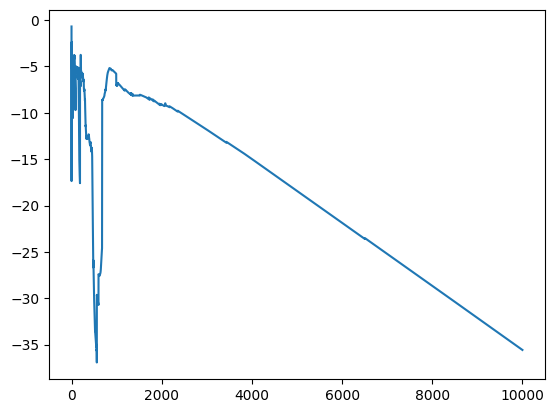

In [275]:
plt.plot(np.arange(len(losses)), [-1* l for l in losses])

In [265]:
train_sgd(objective, objective_grad, ac_X_train.T, ac_y_train, scaling=True, lamb=10)

KeyboardInterrupt: 

## Use Jax autograd

In [14]:
from jax import grad, jit, vmap
from jax import numpy as jnp

In [15]:
LMBD = 0.5
BIG = 1e10
X = ac_X_train
y = ac_y_train
k = jnp.unique(ac_y_train).size

def jphi(beta, thresholds):
    phi = 1 / (1 + jnp.exp(jnp.dot(beta.T, X) - thresholds))
    return phi

def jl1_regularizer(beta):
    return LMBD * jnp.sum(jnp.abs(beta))

# PROBLEM: Is the objective minimized or maximized?? -> Scipy MINIMIZES
# log likelihood with regularization as objective function
def jobjective(params):
    beta = params[:-k]
    theta = params[-k:]
    thresholds = jnp.array([theta[i] for i in y])
    thresholds_m1 = jnp.array([theta[max(0, i-1)] for i in y]) 

    # fit term
    # PROBLEM: What if diff is negative? -> Log has issues, but value may be meaningful
    idx = (thresholds != 0)
    diff = jnp.zeros_like(thresholds)
    phi_i = jphi(beta, thresholds)
    phi_im1 = jphi(beta, thresholds_m1)
    diff.at[idx].set((phi_i - phi_im1)[idx])
    diff.at[~idx].set(phi_i[~idx])

    loss = jnp.log(diff)
    loss = jnp.nan_to_num(jnp.log(diff), nan=0)
    loss = jnp.sum(loss)

    # regularization term
    loss -= jl1_regularizer(beta)
    
    # scipy MINIMIZES the loss
    loss *= -1

    #print("avg loss:", loss.mean())
    return loss


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [19]:
from scipy.optimize import minimize

LMBD = 0.01
BIG = 1e10
X = ac_X_train.T
y = ac_y_train
k = jnp.unique(ac_y_train).size
params = np.zeros(ac_X_train.shape[1] + k)

params_ones = np.ones(ac_X_train.shape[1] + k)

params_warm_start = [0.47077975,  0.        ,  0.37275445,  0.        ,  0.        ,
        -0.2718176 ,  0.01834662,  0.27956828,  0.        ,  0.00906079,
         0.        ,  0.22041753, -0.1378634 ,  0.18726233, -0.08640451,
         0.08268969, -0.26427331,  0.        , -0.28873376, -0.24587408,
         0.        , -0.07656282, -0.02134246,  0.59662556,  0.05288458,
         0.        ,  1.71402649,  0.10353958,  0.        , 0,  -0.48783945,
        -0.62012817, -1.75287372, -2.09708938]



objective_jaxder = grad(jobjective)
minimize(jobjective, params, jac=objective_jaxder, method="BFGS")

/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:141: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:382: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: inf
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 1.000e-02  1.000e-02 ...  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 18
     njev: 7